## Suggested workflow

    [] Get the data for materials with both elastic properties and ones without
    [] Train a model using materials data with elastic props
    [] Test my model with materials having calculated elastic properties
    [] Plot the results for a perspective on the accuracies
    [] Then use the model to predict the elastic props of materials without
    [] Plot the results to get a feel of the magnitude of the predicted elastic props
    [] Get a select few of the materials with predicted high props and study more


### Step 1: Get the data for materials with both elastic properties and ones without

In [80]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

%matplotlib inline


In [2]:
API_TOKEN = os.environ.get("MPTOKEN")
DATA_PATH = ""
SCRIPT_PATH = ""
ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])


In [3]:
## Contact the materials database API and get all Tarnery materials in the database
## - Will filter for the Metals and Nitrates later

try:
    with open(os.path.join(ROOT_DIR, "candidates.json"), 'r') as fo:
        print(f"Found candidates json file, using data from it...")
        materials = json.load(fo)

except Exception as e:
    print(f"Could not get candidates json file, getting data and creating cson file")
    
    mpr = MPRester(API_TOKEN)
    # mpr.materials.available_fields

    crt = {
        # 'elements': {'$all': ['N']},
        'nelements': 3,
        # 'band_gap': {'$lt': 1},
    }
    prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
            'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

    materials = mpr.query(criteria=crt, properties=prt)

    with open(os.path.join(ROOT_DIR, "candidates.json"), 'w') as fo:
        json.dump(materials, fo, indent=2)

Found candidates json file, using data from it...


In [4]:
print([x['pretty_formula'] for x in materials[:20]])

['AcEuAu2', 'NiAgSe2', 'PrSiAg', 'Cd(AgI2)2', 'RbAg3Se2', 'CrAgS2', 'CaAgBi', 'AgPPd5', 'TmAgTe2', 'TmAgS2', 'CeMgAg', 'YSiAg', 'TlAgPd2', 'CaInAg2', 'CaCdAg2', 'ZrAgHg2', 'NaAg2Pd', 'LiAgPd2', 'Ba2CdAg', 'AgPd2Au']


In [5]:
CANDIDATES_WITH = []  # A list of candidate materials with ealstic props
CANDIDATES_WITHOUT = [] # A list of candidate materials without ealstic props

for mat in materials:
    
    if mat['elasticity'] is None:
        CANDIDATES_WITHOUT.append(mat)
    else:
        CANDIDATES_WITH.append(mat)
    

print(f"Total Candidates: {len(materials)}")
print(f"Candidated found with elastic props: {len(CANDIDATES_WITH)}")
print(f"Candidated found without elastic props: {len(CANDIDATES_WITHOUT)}")

Total Candidates: 59023
Candidated found with elastic props: 7372
Candidated found without elastic props: 51651


### Step 2: Train a model using materials data with elastic props
##### Step 2.1 Create The Training data

In [9]:
ID_PROPS_DATA = []

## Create CIF files
print(f"Creating CIF files...")
for i in CANDIDATES_WITH:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = i['elasticity']['K_VRH']

    with open(os.path.join(ROOT_DIR, f"src/data/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating training data.")




Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating training data.


##### Step 2.2 Train the model

In [21]:
main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/data")

EPOCHS = 20
run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
# cmd = "python -c print('Hello-world')"
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERROR >> {err.decode('utf-8')}")
# print(result.decode("utf-8"))


python "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 20 "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/data"
OUTPUT >> Epoch: [0][0/18]	Time 9.490 (9.490)	Data 8.329 (8.329)	Loss 1.7985 (1.7985)	MAE 83.608 (83.608)
Epoch: [0][10/18]	Time 9.064 (9.431)	Data 7.951 (8.366)	Loss 0.4236 (1.4363)	MAE 35.145 (67.307)
Test: [0/6]	Time 9.620 (9.620)	Loss 0.6283 (0.6283)	MAE 48.389 (48.389)
 * MAE 48.432
Epoch: [1][0/18]	Time 0.932 (0.932)	Data 0.016 (0.016)	Loss 0.2375 (0.2375)	MAE 27.489 (27.489)
Epoch: [1][10/18]	Time 0.982 (0.987)	Data 0.012 (0.011)	Loss 0.2481 (0.2895)	MAE 25.299 (27.559)
Test: [0/6]	Time 0.242 (0.242)	Loss 0.4795 (0.4795)	MAE 35.140 (35.140)
 * MAE 32.657
Epoch: [2][0/18]	Time 1.016 (1.016)	Data 0.023 (0.023)	Loss 0.2769 (0.2769)	MAE 20.331 (20.331)
Epoch: [2][10/18]	Time 1.039 (0.998)	Data 0.008 (0.014)	Loss 0.1801 (0.1969)	MAE 19.109 (19.805)
Tes

              material  test      result   Unnamed: 3
0  Zn(InSe2)2_mp-34169    30   30.001389   4.6285E-05
1    Pm2ZnPb_mp-862727    61   61.004147  6.79767E-05
2    PmZnAu2_mp-862974    84   84.009552  0.000113714
3     CeAl3Pd2_mp-4785   116  116.034271  0.000295442
4     Ba(NO3)2_mp-4396    28   28.008942  0.000319345
Working on the scatter plot...
Working on the bar plot...
Widht = 290
Done creating plots


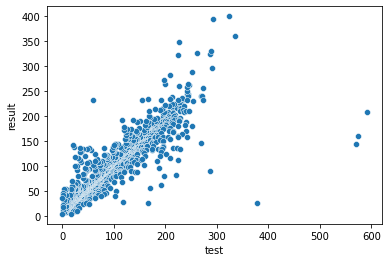

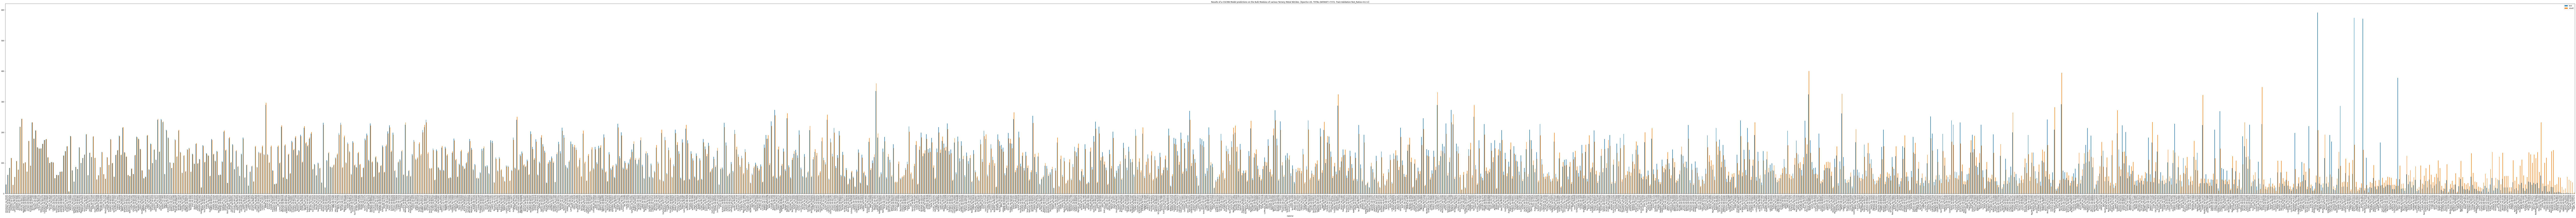

In [26]:
result_file = os.path.join(ROOT_DIR, "src/test_results.csv")

df = pd.read_csv(result_file)

df.dropna(subset=['material'], inplace=True)

print(df.head())

#sb.regplot(x="test", y="result", ci=None, data=df, color='r')

print(f"Working on the scatter plot...")
color_dict = dict({'test':'brown',
                  'result':'green'})
sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')

print(f"Working on the bar plot...")
width = int((len(CANDIDATES_WITH) * 1) / 25.4)
print(f"Widht = {width}")
df.plot(x="material", y=["test", "result"], kind='bar', figsize=(width, 22),
        title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs={EPOCHS}, TOTAL-DATASET={len(CANDIDATES_WITH)}, Train-Validation-Test_Ratios=6:2:2]",
        )

print("Done creating plots")

### Step 3: Test my model with materials having calculated elastic properties

##### 3.1 Create data folder for prediction

In [39]:
count = 0
for i in CANDIDATES_WITHOUT:

    ## Filter through only metal nitrides
    if i['band_gap'] < 1:
        continue
    
    if 'N' not in i['elements']:
        continue

    count += 1

print(count)

1176


In [41]:
ID_PROPS_DATA = []



## Create CIF files for materials without elastic props
print(f"Creating CIF files...")
_CANDIDATES_WITHOUT = random.choices(CANDIDATES_WITHOUT, k=20)
for i in CANDIDATES_WITHOUT:

    ## Filter through only metal nitrides
    if i['band_gap'] < 1:
        continue
    
    if 'N' not in i['elements']:
        continue
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = random.randint(1, 999)

    with open(os.path.join(ROOT_DIR, f"src/data_predict/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data_predict/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data_predict/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating predicting data.")

Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating predicting data.


In [45]:

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/data_predict")
bulk_model = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/pre-trained/bulk-moduli.pth.tar")
my_model = os.path.join(ROOT_DIR, "src/17.776MAE_model_best.pth.tar")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

# EPOCHS = 30
# run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{predict_file}\" \"{my_model}\" \"{data_file}\""
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERRORS >> {err.decode('utf-8')}")

python "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/predict.py" "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar" "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/data_predict"
OUTPUT >> => loading model params 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model params 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loading model 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar' (epoch 17, validation 15.8565092086792)
Test: [0/5]	Time 30.679 (30.679)	Loss 49.6809 (49.6809)	MAE 407.722 (407.722)
 ** MAE 419.971

ERRORS >> c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\venv\lib\site-packages\pymatgen\io\cif.py:1160: User

             material  test      result
0  B2(CN2)3_mp-989468   799  473.001282
1  B2(CN2)3_mp-989466   424  434.544769
2  SrC7N10_mp-1245820   622  426.541840
3  CaC7N10_mp-1247296   713  426.433441
4  PbC7N10_mp-1246015   178  426.148743
Working on the bar plot...
Widht = 40
Done creating plots


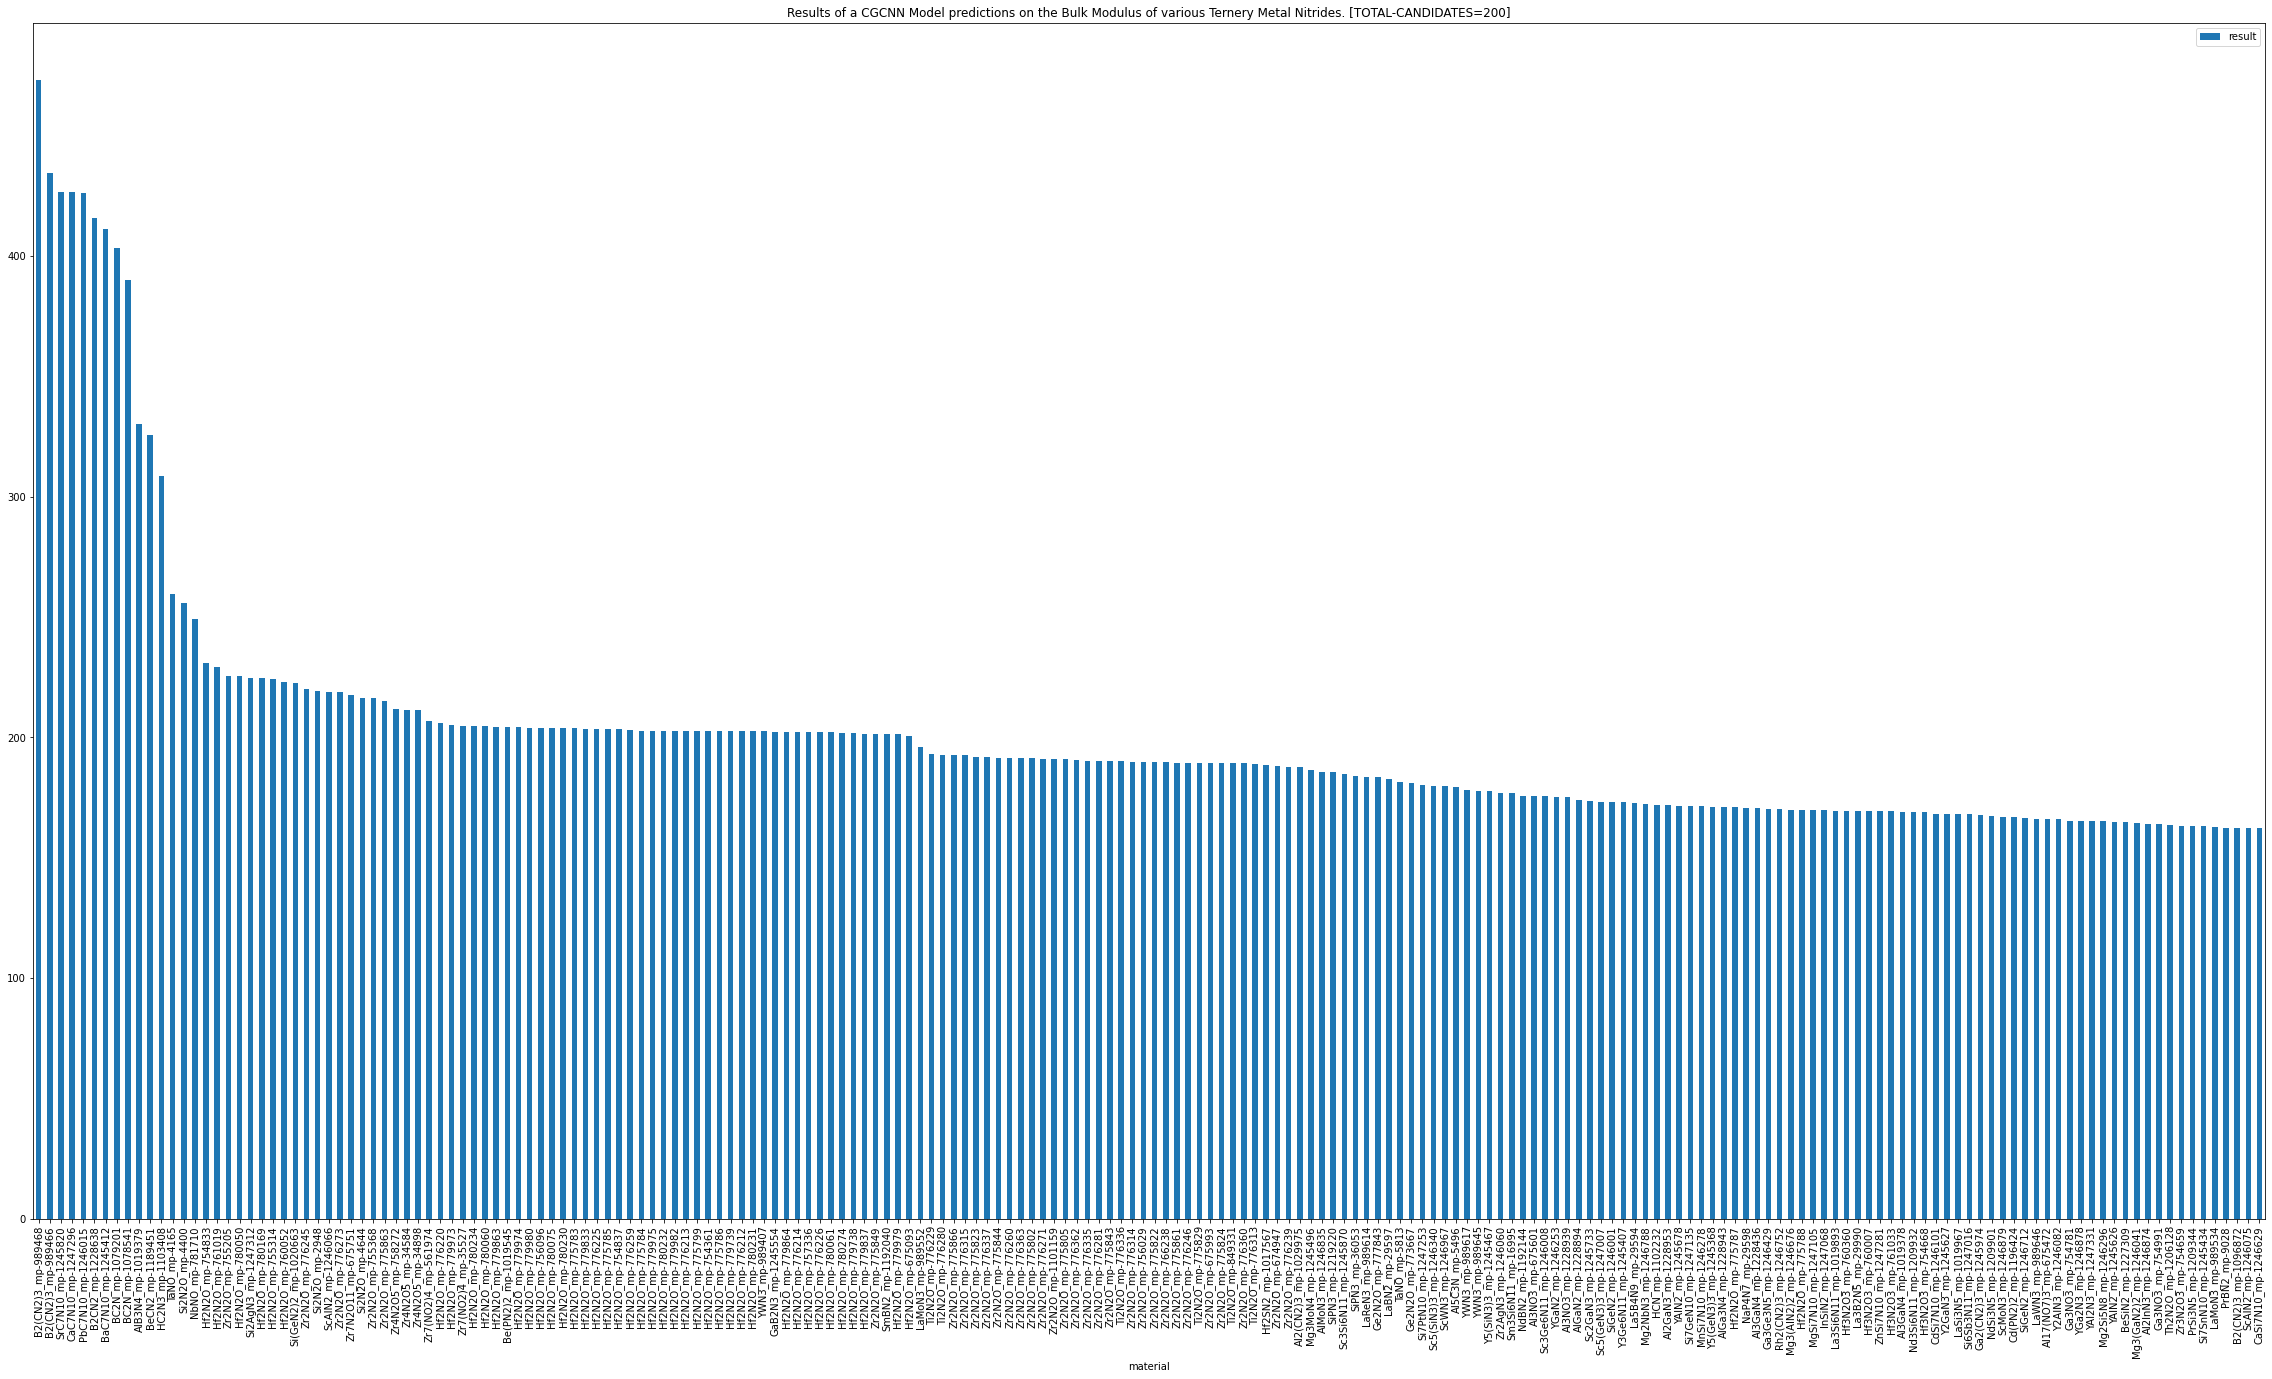

In [66]:
result_file = os.path.join(ROOT_DIR, "src/predict_results.csv")

df = pd.read_csv(result_file)

df = df[:200]

df.dropna(subset=['material'], inplace=True)

print(df.head())

print(f"Working on the bar plot...")
width = int((df.shape[0] * 1) / 5)
print(f"Widht = {width}")
df.plot(x="material", y="result", kind='bar', figsize=(width, 22),
        title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [TOTAL-CANDIDATES={df.shape[0]}]",
        )

print("Done creating plots")

##### Show Performance of the model on well known materials

In [14]:
## Get the properties for the common materials
mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': ['mp-66', 'mp-984', 'mp-492', 'mp-631']}
}
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
        'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

materials = mpr.query(criteria=crt, properties=prt)

In [19]:
for m in materials: print(m['pretty_formula'])

TiN
TiC
C
BN


In [22]:
ID_PROPS_DATA = []
## Create CIF files for materials without elastic props
print(f"Creating CIF files...")
for i in materials:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = random.randint(1, 999)

    with open(os.path.join(ROOT_DIR, f"src/data_common/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data_common/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data_common/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating predicting data.")

Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating predicting data.


In [83]:

predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/data_common")
my_model = os.path.join(ROOT_DIR, "src/17.776MAE_model_best.pth.tar")

cmd = f"python \"{predict_file}\" \"{my_model}\" \"{data_file}\""
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERRORS >> {err.decode('utf-8')}")

python "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/predict.py" "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar" "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/data_common"
OUTPUT >> => loading model params 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model params 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loading model 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model 'c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar' (epoch 17, validation 15.8565092086792)
Test: [0/1]	Time 0.129 (0.129)	Loss 15.3950 (15.3950)	MAE 245.907 (245.907)
 ** MAE 245.907

ERRORS >> c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\venv\lib\site-packages\pymatgen\io\cif.py:1160: UserWar

     material  experimental   predicted
0     C_mp-66         436.0  343.799286
1   BN_mp-984         103.0  287.590332
2  TiC_mp-631         253.0  189.237152
3  TiN_mp-492         259.0  217.655197
Working on the bar plot...
Widht = 0
Done creating plots


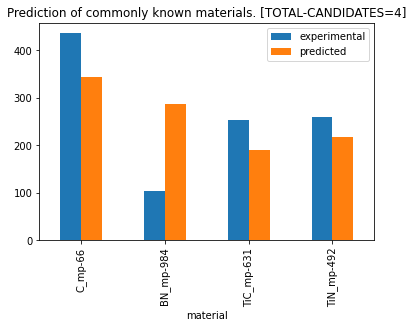

In [85]:
result_file = os.path.join(ROOT_DIR, "src/predict_results.csv")

df = pd.read_csv(result_file)

lis = []
for i in df.to_dict(orient='split')['data']:
    result_dict = {}
    for j in materials:
        if j['material_id'] in i[0]:
            result_dict['material'] = i[0]
            result_dict['experimental'] = j['elasticity']['K_VRH']
            result_dict['predicted'] = i[-1]
        
    lis.append(result_dict)

df = pd.DataFrame(lis)
    
print(df)

print(f"Working on the bar plot...")
width = int((df.shape[0] * 1) / 5)
print(f"Widht = {width}")
df.plot(x="material", y=["experimental", "predicted"], kind='bar',
        title=f"Prediction of commonly known materials. [TOTAL-CANDIDATES={df.shape[0]}]",
        )

print("Done creating plots")